The Meterstick package provides a concise and flexible syntax to describe and execute
routine data analysis tasks. The easiest way to learn to use Meterstick is by example.

# For External users

You can open this notebook in [Google Colab](https://colab.research.google.com/github/google/meterstick/blob/master/meterstick_demo.ipynb).

## Installation

You can install from pip for the stable version

In [ ]:
#@test {"skip": true}
!pip install meterstick

or from GitHub for the latest version.

In [ ]:
#@test {"skip": true}
!git clone https://github.com/google/meterstick.git
import sys, os
sys.path.append(os.getcwd())

# Demo Starts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from meterstick import *

In [ ]:
np.random.seed(42)
platform = ('Desktop', 'Mobile', 'Tablet')
exprs = ('ctrl', 'expr')
country = ('US', 'non-US')
size = 1000
impressions = np.random.randint(10, 20, size)
clicks = impressions * 0.1 * np.random.random(size)
df = pd.DataFrame({'impressions': impressions, 'clicks': clicks})
df['platform'] = np.random.choice(platform, size=size)
df['expr_id'] = np.random.choice(exprs, size=size)
df['country'] = np.random.choice(country, size=size)
df['cookie'] = np.random.choice(range(5), size=size)

df.loc[df.country == 'US', 'clicks'] *= 2
df.loc[(df.country == 'US') & (df.platform == 'Desktop'), 'impressions'] *= 4
df.head()

,impressions,clicks,platform,expr_id,country,cookie
0,16,0.409625,Desktop,ctrl,non-US,2
1,13,0.943924,Desktop,expr,non-US,2
2,17,1.008037,Tablet,ctrl,non-US,3
3,14,0.143098,Tablet,expr,non-US,3
4,16,1.470001,Desktop,ctrl,non-US,2


# Simple Metrics
There are many built-in simple Metrics in Meterstick. They directly operate on a DataFrame.

## Sum

In [ ]:
Sum('clicks').compute_on(df)

,sum(clicks)
0,1099.946824


## Count

In [ ]:
Count('country').compute_on(df)

,count(country)
0,1000


In [ ]:
Count('country', distinct=True).compute_on(df)

,count(distinct country)
0,2


## Max

In [ ]:
Max('clicks').compute_on(df)

,max(clicks)
0,3.782826


## Min

In [ ]:
Min('clicks').compute_on(df)

,min(clicks)
0,0.000855


## Mean

In [ ]:
Mean('clicks').compute_on(df)

,mean(clicks)
0,1.099947


###Weighted Mean

In [ ]:
Mean('clicks', 'impressions').compute_on(df)

,impressions-weighted mean(clicks)
0,1.253466


##Quantile

In [ ]:
Quantile('clicks').compute_on(df) # Default is median.

,"quantile(clicks, 0.5)"
0,0.926113


In [ ]:
Quantile('clicks', 0.2).compute_on(df)

,"quantile(clicks, 0.2)"
0,0.382284


In [ ]:
Quantile('clicks', (0.2, 0.5)).compute_on(df) # Quantile can take multiple quantiles.

,"quantile(clicks, 0.2)","quantile(clicks, 0.5)"
0,0.382284,0.926113


### Interpolation
You can specify how you want to interpolate the quantile. It could be any of (‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’).

In [ ]:
Quantile('clicks', 0.5, interpolation='higher').compute_on(df)

,"quantile(clicks, 0.5)"
0,0.927078


### Weighted Quantile

In [ ]:
Quantile('clicks', weight='impressions').compute_on(df)

,"impressions-weighted quantile(clicks, 0.5)"
0,1.100915


##Variance

In [ ]:
Variance('clicks').compute_on(df)

,var(clicks)
0,0.635262


###Biased Variance
The default Variance is unbiased, namely, the divisor used in calculations is N - 1. You could set unbiased=False to use N as the divisor.

In [ ]:
Variance('clicks', unbiased=False).compute_on(df)

,var(clicks)
0,0.634627


### Weighted Variance

In [ ]:
Variance('clicks', weight='impressions').compute_on(df)

,impressions-weighted var(clicks)
0,0.757683


##Standard Deviation

In [ ]:
StandardDeviation('clicks').compute_on(df)

,sd(clicks)
0,0.797033


### Biased Standard Deviation
Similar to biased Variance, it's possible to compute biased standard deviation.

In [ ]:
StandardDeviation('clicks', False).compute_on(df)

,sd(clicks)
0,0.796635


### Weighted Standard Deviation

In [ ]:
StandardDeviation('clicks', weight='impressions').compute_on(df)

,impressions-weighted sd(clicks)
0,0.87045


##Coefficient of Variation

In [ ]:
CV('clicks').compute_on(df)

,cv(clicks)
0,0.724611


##Correlation

In [ ]:
Correlation('clicks', 'impressions').compute_on(df)

,"corr(clicks, impressions)"
0,0.249193


###Weighted Correlation

In [ ]:
Correlation('clicks', 'impressions', weight='impressions').compute_on(df)

,"impressions-weighted corr(clicks, impressions)"
0,0.289402


##Covariance

In [ ]:
Cov('clicks', 'impressions').compute_on(df)

,"cov(clicks, impressions)"
0,3.402773


###Weighted Covariance

In [ ]:
Cov('clicks', 'impressions', weight='impressions').compute_on(df)

,"impressions-weighted cov(clicks, impressions)"
0,5.895056


# Slicing
You can group your DataFrame and compute the Metrics on slices.

In [ ]:
Sum('clicks').compute_on(df, 'country')

,sum(clicks)
country,
US,751.791138
non-US,348.155686


In [ ]:
Mean('clicks').compute_on(df, ['platform', 'country'])

mean(clicks)
platform country              
Desktop  US           1.411345
         non-US       0.688706
Mobile   US           1.458064
         non-US       0.726992
Tablet   US           1.527596
         non-US       0.729505

# Multiple Metrics
You can put multiple Metrics into a MetricList and compute them together. It's not only makes your codes terser, it might make the computation much faster. See Caching section for more infomation.

In [ ]:
MetricList((Sum('clicks'), Count('clicks'))).compute_on(df)

,sum(clicks),count(clicks)
0,1099.946824,1000


#Arithmetic of Metrics
You can do many arithmetic operations on Metrics. It can also be between a Metric and a scalar. You can call set_name() to give your composite Metric a new name. Internally, we operate on the results returned by Metrics with return_dataframe=False to avoid incompatible DataFrame columns names. However, if both Metrics return DataFrames even when return_dataframe is set to False (for example, Operations discussed below always return a DataFrame.), you might get lots of NAs. The solution is use rename_columns() to unify the column names. See section "Compare the standard errors between Jackknife and Bootstrap" for an example.

### Add

In [ ]:
(Sum('clicks') + 1).compute_on(df)

,sum(clicks) + 1
0,1100.946824


In [ ]:
sum((Sum('clicks'), Sum('impressions'), 1)).compute_on(df)

,0 + sum(clicks) + sum(impressions) + 1
0,23243.946824


In [ ]:
sum((Sum('clicks'), Sum('impressions'), 1)).set_name('meaningless sum').compute_on(df)

,meaningless sum
0,23243.946824


### Divide

In [ ]:
(Sum('clicks') / Sum('impressions')).compute_on(df)

,sum(clicks) / sum(impressions)
0,0.049675


####Ratio
Since division between two Sums is common, we make a Ratio() Metric as a syntax sugar. Its third arg is the name for the Metric and is optional.

In [ ]:
Ratio('clicks', 'impressions', 'ctr').compute_on(df)

,ctr
0,0.049675


We also support many other common arithmetic operations.

In [ ]:
MetricList(
    (Sum('clicks') - 1,
     -Sum('clicks'),
     2 * Sum('clicks'),
     Sum('clicks')**2,
     2**Mean('clicks'),
     (Mean('impressions')**Mean('clicks')).set_name('meaningless power'))
    ).compute_on(df, melted=True)

,Value
Metric,
sum(clicks) - 1,1.098947e+03
-sum(clicks),-1.099947e+03
2 * sum(clicks),2.199894e+03
sum(clicks) ^ 2,1.209883e+06
2 ^ mean(clicks),2.143468e+00
meaningless power,3.017787e+01


# Output Format
There are two options for you to control the format of the return.
1. return_dataframe: Default True, if False, we try to return a scalar or pd.Series. For complex Metrics it might have no effect and a DataFrame is always returned. For example, all Metrics in the Operations section below always return a DataFrame.

  return_dataframe has different effect on MetricList. If False, MetricList will return a list of DataFrames instead of trying to concat them. This is a convenient way to compute incompatible Metrics together to maximize caching (see section Caching also). There is an attribute "children_return_dataframe" in MetricList which will be passed to children Metrics as their return_dataframe so you can get a list of numbers or pd.Series.
2. melted: Dafault False. It decides if the returned DataFrame is in wide/unmelted or long/melted form. It doesn't have effect if the return is not a DataFrame. 
  - Long/melted means the leftmost index is 'Metric' so

    `MetricList((m1, m2)).compute_on(df, melted=True).loc[m1.name] ≡ m1.compute_on(df, melted=True)`

  - Wide/unmelted means the outermost column index is 'Metric' so

    `MetricList((m1, m2)).compute_on(df)[m1.name] ≡ m1.compute_on(df)`

In [ ]:
Sum('clicks').compute_on(df, return_dataframe=False)

1099.9468240093606

In [ ]:
Count('clicks').compute_on(df, ['platform', 'country'], return_dataframe=False)

platform  country
Desktop   US         182
          non-US     164
Mobile    US         154
          non-US     168
Tablet    US         177
          non-US     155
Name: count(clicks), dtype: int64

In [ ]:
Mean('clicks').compute_on(df, melted=True)

,Value
Metric,
mean(clicks),1.099947


In [ ]:
MetricList((Sum('clicks'), Count('clicks'))).compute_on(df, 'country')

,sum(clicks),count(clicks)
country,,
US,751.791138,513
non-US,348.155686,487


In [ ]:
Quantile('clicks', [0.2, 0.7]).compute_on(df, 'country', melted=True)

Value
Metric                country          
quantile(clicks, 0.2) US       0.609408
                      non-US   0.276149
quantile(clicks, 0.7) US       1.939392
                      non-US   0.925534

In [ ]:
# Don't worry. We will talk more about the pipeline operator "|" later.
(MetricList((Sum('clicks'), Count('clicks')))
 | Jackknife('cookie')
 | compute_on(df, 'country'))

Metric  sum(clicks)              count(clicks)             
              Value Jackknife SE         Value Jackknife SE
country                                                    
US       751.791138    17.415592         513.0    11.906301
non-US   348.155686     7.489326         487.0    15.104966

In [ ]:
(MetricList((Sum('clicks'), Count('clicks')))
 | Bootstrap(n_replicates=100)
 | compute_on(df, 'country', melted=True))

Value  Bootstrap SE
Metric        country                          
sum(clicks)   US       751.791138     20.486990
              non-US   348.155686      9.101984
count(clicks) US       513.000000      0.000000
              non-US   487.000000      0.000000

# Operations

An Operation is a special type of Metric that is built on top of another Metric (called a "child").  A Metric is anything that has the compute_on() method, so the child doesn't need to be a simple Metric like Sum. It could be a MetricList, a composite Metric, or even another Operation.

##Distribution
Compute the child Metric on a DataFrame grouped by a column, then normalize the numbers to 1 within group.

In [ ]:
Distribution('country', Sum('clicks')).compute_on(df)

,Distribution of sum(clicks)
country,
US,0.68348
non-US,0.31652


It's equal to

In [ ]:
(Sum('clicks').compute_on(df, 'country') /
 Sum('clicks').compute_on(df, return_dataframe=False))

,sum(clicks)
country,
US,0.68348
non-US,0.31652


Distribution has an alias Normalize.

In [ ]:
Normalize('country', Sum('clicks')).compute_on(df)

,Distribution of sum(clicks)
country,
US,0.68348
non-US,0.31652


##Cumulative Distribution
Similar to Distribution except that it returns the cumulative sum after normalization, but unlike Distribution the order of the cumulating column matters. As the result, we always sort the column and there is an 'order' arg for you to customize the ordering.

In [ ]:
CumulativeDistribution('country', MetricList(
    (Sum('clicks'), Sum('impressions')))).compute_on(df)

,Cumulative Distribution of sum(clicks),Cumulative Distribution of sum(impressions)
country,,
US,0.68348,0.682247
non-US,1.00000,1.000000


In [ ]:
CumulativeDistribution(
    'country', Sum('clicks'), order=('non-US', 'US')).compute_on(df, 'platform')

Cumulative Distribution of sum(clicks)
platform country                                     
Desktop  non-US                              0.305419
         US                                  1.000000
Mobile   non-US                              0.352301
         US                                  1.000000
Tablet   non-US                              0.294878
         US                                  1.000000

In [ ]:
CumulativeDistribution(
    'country', MetricList((Sum('clicks'), Sum('impressions')))
).compute_on(df, melted=True)

Value
Metric                                   country          
Cumulative Distribution of sum(clicks)      US       0.683480
                                         non-US   1.000000
Cumulative Distribution of sum(impressions) US       0.682247
                                         non-US   1.000000

##PercentChange
Computes the percent change to a certain group on the DataFrame returned by the child Metric. The returned value is the # of percent points.

In [ ]:
PercentChange('country', 'US', Mean('clicks')).compute_on(df)

,mean(clicks) Percent Change
country,
non-US,-51.217428


In [ ]:
mean = Mean('clicks').compute_on(df, 'country')
(mean.loc['non-US'] / mean.loc['US'] - 1) * 100

mean(clicks)   -51.217428
dtype: float64

You can include the base group in your result.

In [ ]:
PercentChange(
    'country',
    'US',
    MetricList((Count('clicks'), Count('impressions'))),
    include_base=True).compute_on(df, 'platform')

count(clicks) Percent Change  count(impressions) Percent Change
platform country                                                                 
Desktop  US                           0.000000                           0.000000
         non-US                      -9.890110                          -9.890110
Mobile   US                           0.000000                           0.000000
         non-US                       9.090909                           9.090909
Tablet   US                           0.000000                           0.000000
         non-US                     -12.429379                         -12.429379

You can also specify multiple columns as the condition columns, then your base value should be a tuple.

In [ ]:
PercentChange(
    ['country', 'platform'],
    ('US', 'Desktop'),
    MetricList((Count('clicks'), Count('impressions'))),
    include_base=True).compute_on(df)

count(clicks) Percent Change  count(impressions) Percent Change
country platform                                                                 
US      Desktop                       0.000000                           0.000000
        Mobile                      -15.384615                         -15.384615
        Tablet                       -2.747253                          -2.747253
non-US  Desktop                      -9.890110                          -9.890110
        Mobile                       -7.692308                          -7.692308
        Tablet                      -14.835165                         -14.835165

##Absolute Change
Very similar to PercentChange, but the absolute difference is returned.

In [ ]:
AbsoluteChange('country', 'US', Mean('clicks')).compute_on(df)

,mean(clicks) Absolute Change
country,
non-US,-0.750581


You can also include the base group in your result.

In [ ]:
AbsoluteChange(
    'country', 'US', Count('clicks'), include_base=True).compute_on(
        df, 'platform', melted=True)

Value
Metric                        platform country       
count(clicks) Absolute Change Desktop  US           0
                                       non-US     -18
                              Mobile   US           0
                                       non-US      14
                              Tablet   US           0
                                       non-US     -22

##Cochran-Mantel-Haenszel statistics
Please refer to the Wikepedia [page](https://en.wikipedia.org/wiki/Cochran%E2%80%93Mantel%E2%80%93Haenszel_statistics) for its definition. Besides the condition column and baseline key that PercentChange and AbsoluteChange take, CMH also needs a column to  stratify. The child Metric must be a ratio of two single-column Metrics or CMH doesn't make sense. So instead of passing
    
    AbsoluteChange(MetricList([a, b])) / AbsoluteChange(MetricList([c, d])),
please use
    
    MetricList([AbsoluteChange(a) / AbsoluteChange(c),
              AbsoluteChange(b) / AbsoluteChange(d)]).

In [ ]:
ctr = Ratio('clicks', 'impressions')
MH('country', 'US', 'platform', ctr).compute_on(df)  # stratified by platform

,sum(clicks) / sum(impressions) MH Ratio
country,
non-US,-27.206216


## Standard Errors

###Jackknife
Unlike all Metrics we have seen so far, Jackknife returns a multiple-column DataFrame because by default we return point estimate and standard error.

In [ ]:
Jackknife('cookie', MetricList((Sum('clicks'), Sum('impressions')))).compute_on(df)

Metric  sum(clicks)              sum(impressions)             
              Value Jackknife SE            Value Jackknife SE
0       1099.946824    21.984759          22143.0   766.551342

In [ ]:
metrics = MetricList((Sum('clicks'), Sum('impressions')))
Jackknife('cookie', metrics).compute_on(df, 'country', True)

Value  Jackknife SE
Metric           country                            
sum(clicks)      US         751.791138     17.415592
                 non-US     348.155686      7.489326
sum(impressions) US       15107.000000    639.214017
                 non-US    7036.000000    243.124330

You can also specify a confidence level, the we'll return the confidence interval. The returned DataFrame also comes with a display() method for visualization which will highlight significant changes. To customize the display(), please take a look at confidence_interval_display_demo.ipynb.

In [ ]:
Jackknife('cookie', metrics, 0.9).compute_on(df)

Metric  sum(clicks)                     ...   sum(impressions)                   
              Value Jackknife CI-lower  ... Jackknife CI-lower Jackknife CI-upper
0       1099.946824        1053.078686  ...       20508.829989       23777.170011

[1 rows x 6 columns]

In [ ]:
#@test {"skip": true}
res = (
    MetricList((Ratio('clicks', 'impressions', 'ctr'), Sum('clicks')))
    | PercentChange('country', 'US')
    | Jackknife('cookie', confidence=0.9)
    | compute_on(df, 'platform'))
res.display()

Dimensions,ctr,sum(clicks)
USDesktop,0.0250,256.8647
non-USDesktop,"0.047790.44%[65.99, 114.89] %","112.9478-56.03%[-66.78, -45.28] %"
USMobile,0.0994,224.5419
non-USMobile,"0.0513-48.37%[-54.73, -42.02] %","122.1347-45.61%[-57.18, -34.04] %"
USTablet,0.1045,270.3845
non-USTablet,"0.0495-52.67%[-55.69, -49.66] %","113.0732-58.18%[-66.53, -49.83] %"


###Bootstrap
The output is similar to Jackknife. The different args are 
  - unit: The unique values in unit column will be used as the resampling buckets. If None, we bootstrap on rows.
  - n_replicates: The number of resamples. Default to 10000, which is recommended in Tim Hesterberg's [What Teachers Should Know About the Bootstrap](https://amstat.tandfonline.com/doi/full/10.1080/00031305.2015.1089789). Here we use a smaller number for faster demonstration.

In [ ]:
np.random.seed(42)
Bootstrap(None, Sum('clicks'), 100).compute_on(df)

Metric  sum(clicks)             
              Value Bootstrap SE
0       1099.946824    25.179947

In [ ]:
np.random.seed(42)
Bootstrap('cookie', Sum('clicks'), 100).compute_on(df, 'country')

Metric  sum(clicks)             
              Value Bootstrap SE
country                         
US       751.791138    19.465798
non-US   348.155686     8.782856

In [ ]:
np.random.seed(42)
Bootstrap('cookie', Sum('clicks'), 100, 0.95).compute_on(df, 'country')

Metric  sum(clicks)                                      
              Value Bootstrap CI-lower Bootstrap CI-upper
country                                                  
US       751.791138         713.166771         790.415504
non-US   348.155686         330.728594         365.582779

In [ ]:
#@test {"skip": true}
np.random.seed(42)
res = (
    MetricList((Ratio('clicks', 'impressions', 'ctr'), Sum('impressions')))
    | AbsoluteChange('country', 'US')
    | Bootstrap(None, n_replicates=100, confidence=0.9)
    | compute_on(df, 'platform'))
res.display()

Dimensions,ctr,sum(impressions)
USDesktop,0.0250,10260.0000
non-USDesktop,"0.04770.0226[0.0186, 0.0267]","2369.0000-7891.0000[-9085.7312, -6696.2688]"
USMobile,0.0994,2260.0000
non-USMobile,"0.0513-0.0481[-0.0587, -0.0374]","2381.0000121.0000[-340.2922, 582.2922]"
USTablet,0.1045,2587.0000
non-USTablet,"0.0495-0.0551[-0.0628, -0.0473]","2286.0000-301.0000[-770.0108, 168.0108]"


#Pipeline
You have already seen this. Instead of

    Jackknife(PercentChange(MetricList(...))).compute_on(df)
you can write

    MetricList(...) | PercentChange() | Jackknife() | compute_on(df)

which is more intuitive. We overwrite the "|" operator on Metric and the \_\_call\_\_() of Operation so a Metric can be pipelined to an Operation. As Operation is a special kind of Metric, so it can bu further pipelined to another Operation. At last, compute_on() takes a Metric from the pipeline and is equavalent to calling metric.compute_on().

#Filter

There is a "where" arg for Metric. It'll be passed to df.query() at the beginning of compute_on(df). By default the filter is not reflected in the name of Metric so same Metrics with different filters would have same column names in the returned DataFrames. It makes combining them easy.

In [ ]:
clicks_us = Sum('clicks', where='country == "US"')
clicks_not_us = Sum('clicks', where='country != "US"')
(clicks_not_us - clicks_us).compute_on(df)

,sum(clicks) - sum(clicks)
0,-403.635452


It's equivalent to

In [ ]:
Sum('clicks') | AbsoluteChange('country', 'US') | compute_on(df)

,sum(clicks) Absolute Change
country,
non-US,-403.635452


#SQL

You can easily get SQL query for all built-in Metrics and Operations, except for weighted Quantile/CV/Correlation/Cov, by calling

> to_sql(sql_table, split_by).

You can also directly execute the query by calling
> compute_on_sql(sql_table, split_by, execute, melted),

where execute is a function that can execute SQL queries. The return is very similar to compute_on().

The dialect it uses is the [standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql) in Google Cloud's BigQuery.


In [ ]:
MetricList((Sum('X', where='Y > 0'), Sum('X'))).to_sql('T', 'grp')

SELECT
  grp,
  SUM(IF(Y > 0, X, NULL)) AS sum_X,
  SUM(X) AS sum_X_1
FROM T
GROUP BY grp

#Custom Metric
We provide many Metrics out of box but we understand there are cases you need more, so we make it easy for you to write you own Metrics.
First you need to understand the dataflow of a DataFrame when it's passed to compute_on(). The dataflow looks like this.

		    <-------------------------------------------compute_on(handles caching)---------------------------------------------->
		    <-------------------------------------compute_through----------------------------------->                            |
		    |                                              <------compute_slices------>             |                            |
		    |                                              |-> slice1 -> compute |    |             |                            |
		df -> df.query(where) -> precompute -> split_data -|-> slice2 -> compute | -> pd.concat  -> postcompute -> manipulate -> final_compute
		                                                   |-> ...			   |

In summary, compute() operates on a slice of data and hence only takes one arg, df. While precompute(), postcompute(), compute_slices(), compute_through() and final_compute() operate on the whole DataFrame so they take the df that has been processed by the dataflow till them and the split_by passed to compute_on(). final_compute() also has access to the original df passed to compute_on() for you to make additional manipulation. manipulate() does common data manipulation like melting and cleaning. Besides wrapping all the computations above, compute_on() also caches the result from compute_through(). Please refer to the section of Caching for more details.

Depending on your case, you can overwrite all the methods, but we suggest you NOT to overwrite compute_on() because it might mess up the caching mechanism, nor manipulate(), because it might not work well with other Metrics' data manipulation. Here are some rules to help you decide.
1. If your Metric has no vectorization over slices, overwrite compute() which only takes one arg, df. To overwrite, you can either create a new class inheriting from Metric or just pass a lambda function into Metric.
2. If you have vectorization logic over slices, overwrite compute_slices().
3. As compute() operates on a slice of data, it doesn't have access to the columns to split_by and the index value of the slice. If you need them, overwrite compute_with_split_by(self, df, split_by, slice_name), which is just a wrapper of compute(), but has access to split_by and the value of current slice, slice_name.
4. The data passed into manipulate() should be a number, a pd.Series, or a wide/unmelted pd.DataFrame.
5. split_data() returns (sub_dataframe, corresponding slice value). You might want to overwrite it for non-vectorized Operations. See section Linear Regression for examples.

Also there are some requirements.
1. Your Metric shouldn't change the input DataFrame inplace or it might not work with other Metrics.
2. Your Metric shouldn't rely on the index of the input DataFrame if you want it to work with Jackknife. The reason is Jackknife might reset the index.


## No Vectorization

In [ ]:
class CustomSum(Metric):
  def __init__(self, var):
    name = 'custom sum(%s)' % var
    super(CustomSum, self).__init__(name)
    self.var = var

  def compute(self, df):
    return df[self.var].sum()

CustomSum('clicks').compute_on(df, 'country')

,custom sum(clicks)
country,
US,751.791138
non-US,348.155686


In [ ]:
Sum('clicks').compute_on(df, 'country')

,sum(clicks)
country,
US,751.791138
non-US,348.155686


CustomSum doesn't have vectorization. It loops through the DataFrame and sum on every slice. As the result, it's slower than vectorized summation.

In [ ]:
#@test {"skip": true}
%%timeit
CustomSum('clicks').compute_on(df, 'country')

100 loops, best of 3: 5.18 ms per loop


In [ ]:
#@test {"skip": true}
%%timeit
Sum('clicks').compute_on(df, 'country')

100 loops, best of 3: 2.13 ms per loop


In [ ]:
#@test {"skip": true}
%%timeit
df.groupby('country')['clicks'].sum()

100 loops, best of 3: 1.45 ms per loop


## With Vectorization

We can do better. Let's implement a Sum with vectorization.

In [ ]:
class VectorizedSum(Metric):
  def __init__(self, var):
    name = 'vectorized sum(%s)' % var
    super(VectorizedSum, self).__init__(name = name)
    self.var = var

  def compute_slices(self, df, split_by):
    if split_by:
      return df.groupby(split_by)[self.var].sum()
    return df[self.var].sum()

VectorizedSum('clicks').compute_on(df, 'country')

,vectorized sum(clicks)
country,
US,751.791138
non-US,348.155686


In [ ]:
#@test {"skip": true}
%%timeit
VectorizedSum('clicks').compute_on(df, 'country')

1000 loops, best of 3: 1.77 ms per loop


## Precompute, postcompute and final_compute

They are useful when you need to preprocess and postprocess the data.

In [ ]:
class USOnlySum(Sum):

  def precompute(self, df, split_by):
    return df[df.country == 'US']

  def postcompute(self, data, split_by):
    print('Inside postcompute():')
    print('Input data: ', data)
    print('Input split_by: ', split_by)
    print('\n')
    return data

  def final_compute(self, res, melted, return_dataframe, split_by, df):
    # res is the result processed by the dataflow till now. df is the original
    # DataFrme passed to compute_on().
    print('Inside final_compute():')
    for country in df.country.unique():
      if country not in res.index:
        print('Country "%s" is missing!' % country)
    return res


USOnlySum('clicks').compute_on(df, 'country')

Inside postcompute():
Input data:  country
US    751.791138
Name: clicks, dtype: float64
Input split_by:  ['country']


Inside final_compute():
Country "non-US" is missing!


,sum(clicks)
country,
US,751.791138


## Overwrite using Lambda Functions
For one-off Metrics, you can also overwrite precompute, compute, postcompute, compute_slices and final_compute by passing them to Metric() as lambda functions.

In [ ]:
Metric('sum', compute=lambda x: x['clicks'].sum()).compute_on(df, 'country')

,sum
country,
US,751.791138
non-US,348.155686


##Custom Operation
Writing a custom Operation is a bit more complex. Take a look at the Caching section below as well. Typically an Operation first computes its children Metrics with expanded split_by. Here are some rules to keep in mind.
1. Always use compute_on and compute_child to compute the children Metrics. They handle caching so your Operation can interact with other Metrics correctly.
2. If the Operation extends the split_by when computing children Metrics, you need to register the extra columns added in the \_\_init__().
3. The extra columns should come after the original split_by.
4. If you really cannot obey #2 or #3, you need to overwrite Operation.flush_children(), or it won't work with Jackknife and Bootstrap.
5. Try to vectorize the Operation as much as possible. At least you can compute the children Metrics in a vectorized way by calling compute_child(). It makes the caching of the children Metrics more available.
6. Jackknife takes shortcuts when computing leave-one-out (LOO) estimates for Sum, Mean and Count, so if you want your Operation to work with Jackknife fast, delegate computations to Sum, Mean and Count as much as possible. See section Linear Regression for a comparison.
7. For the same reason, you computation logic should avoid using input df other than in compute_on() and compute_child(). When cutting corners, Jackknife emits None as the input df for LOO estimation. The compute_on() and compute_child() functions know to read from cache but other functions may not know what to do. If your Operation uses df outside the compute_on() and compute_child() functions, you have either to
      * ensure that your computation doesn't break when df is None.
      * set attribute 'precomputable_in_jk' to False (which will force the jackknife to be computed the manual way, which is slower).

Let's see Distribution for an example.

In [ ]:
class Distribution(Operation):
  """Computes the normalized values of a Metric over column(s).

  Attributes:
    extra_index: A list of column(s) to normalize over.
    children: A tuple of a Metric whose result we normalize on. And all other
      attributes inherited from Operation.
  """

  def __init__(self,
               over: Union[Text, List[Text]],
               child: Optional[Metric] = None,
               **kwargs):
    self.over = over
    # The 3rd argument is the extra column that will be added to split_by. It'll
    # be converted to a list then assigned to self.extra_index.
    super(Distribution, self).__init__(child, 'Distribution of {}', over,
                                       **kwargs)

  def compute_slices(self, df, split_by=None):
    # extra_index is after the split_by.
    lvls = split_by + self.extra_index if split_by else self.extra_index
    res = self.compute_child(df, lvls)
    total = res.groupby(level=split_by).sum() if split_by else res.sum()
    return res / total

# Caching

tl;dr: Reuse Metrics as much as possible and compute them together.

Computation can be slow so it'd nice if we pass in the same DataFrame multiple
times the computation is actually only done once. The difficulty is that
DataFrame is mutable so it's hard to decide whether we really saw this DataFrame
before. However, in one round of compute_on(), the DataFrame shouldn't change
(our Metrics never change the original DataFrame and your custom Metrics
shouldn't either), so we can cache the result, namely, a Metric appearing in
multiple places will only be computed once. This all happens automatically so
you don't need to worry about it. If you really cannot compute all your Metrics
in one round, there is a "cache_key" arg in compute_on(). What it does is

1.  if the key is in cache, just read the cache;
2.  if not, compute and save the result to cache under the key.

Note:
1. All we check is cache_key, nothing more, so it's your responsibility to
make sure same key really corresponds to the same input DataFrame AND split_by.
2. The caching and retrieving happen in all levels of Metrics, so

  `PercentChange(..., Sum('x')).compute_on(df, cache_key='foo')`

  not only cache the percent change to PercentChange's cache, but also cache

  `Sum('x').compute_through(df)`

  to Sum('x')'s cache. Note it's the output of compute_through() is cached so we
do't need to re-compute just because you change "melted" from True to False.
3. Anything that can be a key of a dict can be used as cache_key, except '_RESERVED' and tuples like ('_RESERVED', ...).

First, let's illustrate that when we don't reuse Metrics, everything gets
computed once as expected.

In [ ]:
class SumWithTrace(Sum):
  def compute_through(self, data, split_by):
    print('Computing %s...' % self.name)
    return super(SumWithTrace, self).compute_through(data, split_by)

sum_clicks = SumWithTrace('clicks', 'sum of clicks')
ctr = SumWithTrace('clicks') / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df)

Computing sum of clicks...
Computing sum(clicks)...
Computing sum(impressions)...


,sum of clicks,sum(clicks) / sum(impressions)
0,1099.946824,0.049675


Now let's see what heppens if we reuse sum_clicks.

In [ ]:
sum_clicks = SumWithTrace('clicks', 'sum of clicks')
ctr = sum_clicks / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df)

Computing sum of clicks...
Computing sum(impressions)...


,sum of clicks,sum of clicks / sum(impressions)
0,1099.946824,0.049675


Then sum_clicks only gets computed once. For Metics that are not quite compatible, you can still put them in a MeticList and set return_dataframe to False to maximize the caching.

In [ ]:
sum_clicks = SumWithTrace('clicks', 'sum of clicks')
jk, s = MetricList(
    [Jackknife('cookie', sum_clicks), sum_clicks],
    children_return_dataframe=False).compute_on(
        df, return_dataframe=False)
print(s)
jk

Computing sum of clicks...
1099.9468240093606


Metric sum of clicks             
               Value Jackknife SE
0        1099.946824    21.984759

If you really cannot compute Metrics together, you can use a cache_key.

In [ ]:
sum_clicks = SumWithTrace('clicks', 'sum of clicks')
ctr = sum_clicks / SumWithTrace('impressions')
sum_clicks.compute_on(df, 'country', cache_key='foo')
ctr.compute_on(df, 'country', cache_key='foo')

Computing sum of clicks...
Computing sum(impressions)...


,sum of clicks / sum(impressions)
country,
US,0.049764
non-US,0.049482


The resulte are cached in ctr, a composite Metric, as well as its children, the Sum Metrics.

In [ ]:
sum_clicks = SumWithTrace('clicks', 'sum of clicks')
ctr = sum_clicks / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df, cache_key='foo')
print('sum_clicks cached: ', sum_clicks.get_cached('foo'))
print('ctr cached: ', ctr.get_cached('foo'))
ctr.compute_on(None, cache_key='foo')

Computing sum of clicks...
Computing sum(impressions)...
sum_clicks cached:  1099.9468240093606
ctr cached:  0.0496746973765687


,sum of clicks / sum(impressions)
0,0.049675


You can flush the cache by calling flush_cache(key, split_by=None, recursive=True, prune=True), where "recursive" means if you want to flush the cache of the children Metrics as well, and "prune" means if the key is not found in current Metric, do you still want to flush the children Metrics or stop early. It's useful when a high level Metric appears in several places then during the flushing we will hit it multiple times. We can save time by stop early.

In [ ]:
sum_clicks = SumWithTrace('clicks', 'sum of clicks')
ctr = sum_clicks / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df, cache_key='foo')
ctr.flush_cache('foo', recursive=False)

Computing sum of clicks...
Computing sum(impressions)...


In [ ]:
sum_clicks.compute_on(None, cache_key='foo')  # sum is not flushed.

,sum of clicks
0,1099.946824


In [ ]:
ctr.in_cache('foo')

False

Though ctr's cache has been flushed, we can still compute ctr from cache because all its children are cached.

In [ ]:
ctr.compute_on(None, cache_key='foo')

,sum of clicks / sum(impressions)
0,0.049675


In [ ]:
ctr.in_cache('foo')

True

We won't be able to re-compute ctr if we recursively flush its cache.

In [ ]:
#@test {"skip": true}
ctr.flush_cache('foo')
sum_clicks.compute_on(None, cache_key='foo')  # sum is flushed too.

Computing sum of clicks...


TypeError: ignored

However, the behavior becomes subtle when Operation is involved.

In [ ]:
sum_clicks = SumWithTrace('clicks')
PercentChange('country', 'US', sum_clicks).compute_on(df, cache_key=42)
sum_clicks.compute_on(None, 'country', cache_key=42)

Computing sum(clicks)...


,sum(clicks)
country,
US,751.791138
non-US,348.155686


Note that it's sum_clicks.compute_on(df, 'country') instead of sum_clicks.compute_on(df) got saved in the cache. The reason is we need the former not the latter to compute the PercentChange. Using sum_clicks.compute_on(df, cache_key=42) will always give you the right result so it's not a big issue, just might confuse you sometime.

In [ ]:
sum_clicks.compute_on(df, cache_key=42)

Computing sum(clicks)...


,sum(clicks)
0,1099.946824


In [ ]:
sum_clicks.compute_on(df, 'country', cache_key=42)

,sum(clicks)
country,
US,751.791138
non-US,348.155686


#Advanced Examples

## Click Split

In [ ]:
np.random.seed(42)
df['duration'] = np.random.random(len(df)) * 200

long_clicks = Sum('clicks', where='duration > 60')
short_clicks = Sum('clicks', where='duration < 30')
click_split = (long_clicks / short_clicks).set_name('click split')
click_split | Jackknife('cookie') | compute_on(df, 'country')

Metric  click split             
              Value Jackknife SE
country                         
US         4.053991     0.421106
non-US     4.327727     0.509220

##Difference in differences

In [ ]:
np.random.seed(42)
df['period'] = np.random.choice(('preperiod', 'postperiod'), size=size)

sum_clicks = Sum('clicks')
ctr = sum_clicks / Sum('impressions')
metrics = (sum_clicks, ctr)
preperiod_clicks = MetricList(metrics, where='period == "preperiod"')
postperiod_clicks = MetricList(metrics, where='period == "postperiod"')
pct = PercentChange('platform', 'Desktop')
did = (pct(postperiod_clicks) - pct(preperiod_clicks)).rename_columns(
    ['clicks% DID', 'ctr% DID'])
Jackknife('cookie', did).compute_on(df)

Metric   clicks% DID                ctr% DID             
               Value Jackknife SE      Value Jackknife SE
platform                                                 
Mobile      0.895517    24.081346 -12.971959    19.153263
Tablet      6.008909    14.408561  -4.274900    22.751797

## Compare the standard errors between Jackknife and Bootstrap

In [ ]:
np.random.seed(42)
sum_clicks = Sum('clicks')
ctr = sum_clicks / Sum('impressions')
metrics = MetricList((sum_clicks, ctr))
(Jackknife('cookie', metrics) /
 Bootstrap('cookie', metrics, 100)).rename_columns(
     pd.MultiIndex.from_product(
         (('sum(clicks)', 'ctr'), ('Value', 'SE')))).compute_on(df, 'country')

sum(clicks)             ctr          
              Value        SE Value        SE
country                                      
US              1.0  0.894677   1.0  1.062502
non-US          1.0  0.852721   1.0  1.203828

## Linear Regression

Here we fit a linear regression on mean values of groups. We show two versions, the former delgates computations to Mean so its Jackknife is faster than the latter which doesn't delegate.

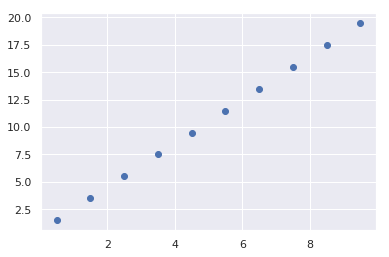

In [ ]:
np.random.seed(42)
size = 1000000
df_lin = pd.DataFrame({'grp': np.random.choice(range(10), size=size)})
df_lin['x'] = df_lin.grp + np.random.random(size=size)
df_lin['y'] = 2 * df_lin.x + np.random.random(size=size)
df_lin['cookie'] = np.random.choice(range(20), size=size)
df_lin_mean = df_lin.groupby('grp').mean()
plt.scatter(df_lin_mean.x, df_lin_mean.y)
plt.show()

In [ ]:
from sklearn import linear_model


class LinearReg(Operation):
  def __init__(self, x, y, grp):
    self.lm = linear_model.LinearRegression()
    # Delegate most of the computations to Mean Metrics.
    child = MetricList((Mean(x), Mean(y)))
    self.grp = grp
    # Register grp as the extra_index.
    super(LinearReg, self).__init__(child, '%s ~ %s' % (y, x), grp)

  def split_data(self, df, split_by=None):
    """The 1st element in yield will be passed to compute()."""
    if not split_by:
      yield self.compute_child(df, self.grp), None
    else:
      # grp needs to come after split_by.
      child = self.compute_child(df, split_by + [self.grp])
      keys, indices = list(zip(*child.groupby(split_by).groups.items()))
      for i, idx in enumerate(indices):
        yield child.loc[idx.unique()].droplevel(split_by), keys[i]

  def compute(self, df):
    self.lm.fit(df.iloc[:, [0]], df.iloc[:, 1])
    return pd.Series((self.lm.coef_[0], self.lm.intercept_))


lr = LinearReg('x', 'y', 'grp')
Jackknife('cookie', lr, 0.95).compute_on(df_lin)

Metric     y ~ x                                      
           Value Jackknife CI-lower Jackknife CI-upper
0       2.000065           1.999928           2.000203
1       0.499577           0.498379           0.500775

In [ ]:
class LinearRegSlow(Metric):
  def __init__(self, x, y, grp):
    self.lm = linear_model.LinearRegression()
    # Doesn't delegate.
    self.x = x
    self.y = y
    self.grp = grp
    super(LinearRegSlow, self).__init__('%s ~ %s' % (y, x))

  def split_data(self, df, split_by=None):
    """The 1st element in yield will be passed to compute()."""
    idx = split_by + [self.grp] if split_by else self.grp
    mean = df.groupby(idx).mean()
    if not split_by:
      yield mean, None
    else:
      keys, indices = list(zip(*mean.groupby(split_by).groups.items()))
      for i, idx in enumerate(indices):
        yield mean.loc[idx.unique()].droplevel(split_by), keys[i]

  def compute(self, df):
    self.lm.fit(df.iloc[:, [0]], df.iloc[:, 1])
    return pd.Series((self.lm.coef_[0], self.lm.intercept_))


lr_slow = LinearRegSlow('x', 'y', 'grp')
Jackknife('cookie', lr_slow, 0.95).compute_on(df_lin)

Metric     y ~ x                                      
           Value Jackknife CI-lower Jackknife CI-upper
0       2.000065           1.999928           2.000203
1       0.499577           0.498379           0.500775

In [ ]:
#@test {"skip": true}
%%timeit
Jackknife('cookie', lr, 0.95).compute_on(df_lin)

1 loops, best of 3: 973 ms per loop


In [ ]:
#@test {"skip": true}
%%timeit
Jackknife('cookie', lr_slow, 0.95).compute_on(df_lin)

1 loops, best of 3: 1.87 s per loop


## LOWESS

In [ ]:
# Mimics that measurements, y, are taken repeatedly at a fixed grid, x.
np.random.seed(42)
size = 10
x = list(range(5))
df_sin = pd.DataFrame({'x': x * size, 'cookie': np.repeat(range(size), len(x))})
df_sin['y'] = np.sin(df_sin.x) + np.random.normal(scale=0.5, size=len(df_sin.x))
df_sin.head(10)

,x,cookie,y
0,0,0,0.248357
1,1,0,0.772339
2,2,0,1.233142
3,3,0,0.902635
4,4,0,-0.873879
5,0,1,-0.117068
6,1,1,1.631077
7,2,1,1.293015
8,3,1,-0.093617
9,4,1,-0.485522


In [ ]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess


class Lowess(Metric):

  def __init__(self, x, y, name=None, where=None):
    self.x = x
    self.y = y
    name = name or 'LOWESS(%s ~ %s)' % (y, x)
    super(Lowess, self).__init__(name, where=where)

  def compute(self, data):
    lowess_fit = pd.DataFrame(
        lowess(data[self.y], data[self.x]), columns=[self.x, self.y])
    return lowess_fit.drop_duplicates().reset_index(drop=True)

In [ ]:
Lowess('x', 'y') | compute_on(df_sin)

,x,y
0,0.0,0.016953
1,1.0,0.592061
2,2.0,0.575784
3,3.0,-0.109848
4,4.0,-1.096083


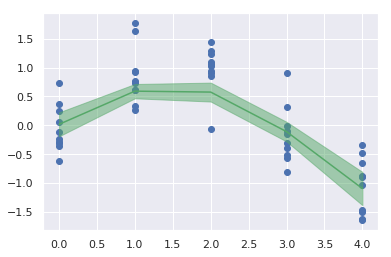

In [ ]:
jk = Lowess('x', 'y') | Jackknife('cookie', confidence=0.9) | compute_on(df_sin)
point_est = jk[('y', 'Value')]
ci_lower = jk[('y', 'Jackknife CI-lower')]
ci_upper = jk[('y', 'Jackknife CI-upper')]

plt.scatter(df_sin.x, df_sin.y)
plt.plot(x, point_est, c='g')
plt.fill_between(
    x, ci_lower,
    ci_upper,
    color='g',
    alpha=0.5)
plt.show()